# Text Generation using Recurrent Neural Network

### Content
- [1. Mounting the google drive to google colab](#1.-Mounting-the-google-drive-to-google-colab)
- [2. Standard Imports for Recurrent Neural Networks](#2.-Standard-Imports-for-Recurrent-Neural-Networks)
- [3. Loading the txt file that is used for RNN](#3.-Loading-the-txt-file-that-is-used-for-RNN)
- [4. Exploring text dataset](#4.-Exploring-text-dataset)
- [5. Numerical encode the sentences and features](#5.-Numerical-encode-the-sentences-and-features)
- [6. train-test-split X and y](#6.-train-test-split-X-and-y)
- [7. Create RNN model](#7.-Create-RNN-model)
- [8. Creating ModelCheckpoint and callback requirements](#8.-Creating-ModelCheckpoint-and-callback-requirements)
- [9.Training my RNN model](#9.Training-my-RNN-model)
- [10. evaluating performance of model](#10.-evaluating-performance-of-model)
- [11. Loading my pre-trained weights to resume training](#11.-Loading-my-pre-trained-weights-to-resume-training)
- [12.Try generating text using help from keras.io](#12.Try-generating-text-using-help-from-keras.io)
- [13. Try correct spelling of generating text](#13.-Try-correct-spelling-of-generating-text)
- [14. Conclusion](#14.-Conclusion)

### 1.  Mounting the google drive to google colab

In [1]:
# mounting the my googledrive to google.colab
# this is needed to save my weights, Neural Network model while it is running
# the model, weights can be accessed at a later time if google colab disconnects

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 2. Standard Imports for Recurrent Neural Networks

In [2]:
from __future__ import print_function

# For preprocessing the text into integer(ids)
# For plotting the accuracy and loss curve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# regular expression to proprocess raw_text
import regex as re

# To instantiate Recurrent Neural Networks
from keras.models import Sequential
# My model will be dense with all the nodes to 'touch'
from keras.layers import Dense, Activation
# LSTM, GRU
from keras.layers import LSTM, GRU
#from keras.optimizers import RMSprop, adam

# to create a callback, this will be a checkpoint
from keras.callbacks import LambdaCallback

# need to create a random seed to create a text, so the model will learn the sequence
import random
import sys
import io

### 3. Loading the txt file that is used for RNN

In [8]:
# cd to pull my txt file from my google drive into google colab
%cd /content/gdrive/My Drive/Capstone/Data/

# filename called 'out.txt'
filename = "rnn_text.txt"

# extract the raw text
raw_text = open(filename, 'r', encoding='utf-8').read()


# lowercase my text
data = raw_text.lower()
# remove url links
data = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',data)
# keep punctuations this time
data = re.sub("[^a-zA-Z.,?!'\";:-]", " ", data)
# strip to remove empty spaces before beginning and end of string
data = data.strip()

/content/gdrive/My Drive/Capstone/Data


### 4. Exploring text dataset

In [9]:
# set - find a list of specific characters 
# list - to convert characters into a list
# sorted - to sort list into alphabetical order
chars = sorted(list(set(data)))

# count of total characters
print('total chars: ', len(chars))

total chars:  36


In [10]:
# mapping the characters to numerical values & vice versa
# this will be crucial for feeding into our RNN model
# and required to map the predicted numerical values back to their corresponding characters

char_indices = dict((c, i) for i, c in enumerate(chars))

# noted that in this list of character mapping, there is no 'z' in text
# noted that ' ' white space is counted as a character
char_indices

{' ': 0,
 '!': 1,
 '"': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 ':': 7,
 ';': 8,
 '?': 9,
 'a': 10,
 'b': 11,
 'c': 12,
 'd': 13,
 'e': 14,
 'f': 15,
 'g': 16,
 'h': 17,
 'i': 18,
 'j': 19,
 'k': 20,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 24,
 'p': 25,
 'q': 26,
 'r': 27,
 's': 28,
 't': 29,
 'u': 30,
 'v': 31,
 'w': 32,
 'x': 33,
 'y': 34,
 'z': 35}

In [11]:
# this will be used from mapping numerical values back to characters
indices_char = dict((i, c) for i, c in enumerate(chars))

indices_char

{0: ' ',
 1: '!',
 2: '"',
 3: "'",
 4: ',',
 5: '-',
 6: '.',
 7: ':',
 8: ';',
 9: '?',
 10: 'a',
 11: 'b',
 12: 'c',
 13: 'd',
 14: 'e',
 15: 'f',
 16: 'g',
 17: 'h',
 18: 'i',
 19: 'j',
 20: 'k',
 21: 'l',
 22: 'm',
 23: 'n',
 24: 'o',
 25: 'p',
 26: 'q',
 27: 'r',
 28: 's',
 29: 't',
 30: 'u',
 31: 'v',
 32: 'w',
 33: 'x',
 34: 'y',
 35: 'z'}

### 5. Numerical encode the sentences and features

In [ ]:
len(data)

1208984

In [13]:
text = data

In [14]:
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 402963


In [15]:
print(sentences[:5])
print(next_chars[:5])

['just auditing this course helped me a lot in learning this language programming. attentive save the ', 't auditing this course helped me a lot in learning this language programming. attentive save the mon', 'uditing this course helped me a lot in learning this language programming. attentive save the money ', 'ting this course helped me a lot in learning this language programming. attentive save the money i w', 'g this course helped me a lot in learning this language programming. attentive save the money i will']
['m', 'e', 'i', 'i', ' ']


In [16]:
len(text)

1208987

In [17]:
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

### 6. train-test-split X and y

X and y are split into train and test sets, **shuffle=False** is used as reviews are written in a sequence

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=42, shuffle=False)

### 7. Create RNN model
 https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6

In [19]:
# Define the model architecture 

def create_model():
    #instantial
    model = Sequential()
    model.add(LSTM(128, input_shape=(maxlen, len(chars))))
    model.add(Dense(len(chars)))
    model.add(Activation('softmax'))
    
    # Compiling the model
    # as my model are one-hot encoded, i will use categorical_crossentropy
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    
    return model

#create the model
model_ckpt= create_model()

In [20]:
model_ckpt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 36)                4644      
_________________________________________________________________
activation (Activation)      (None, 36)                0         
Total params: 89,124
Trainable params: 89,124
Non-trainable params: 0
_________________________________________________________________


### 8. Creating my ModelCheckpoint and callback requirements

In [21]:
from keras.callbacks import ModelCheckpoint

# specifying where my checkpoint files will be stored
filepath = "/content/gdrive/My Drive/Capstone/Data/"

# this ModelCheckpoint save weights and save the best model as it runs
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             save_weights_only=True, save_best_only=True,
                             mode='min',verbose=1 )

In [22]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

In [23]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [24]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [25]:
### combining all of my callbacks

callbacks = [print_callback, checkpoint, reduce_lr]

### 9.Training my RNN model

In [26]:
history = model_ckpt.fit(X_train, y_train, batch_size=128, epochs=100, validation_data =(X_test, y_test),callbacks=callbacks)

Epoch 1/100
2362/2362 [==============================] - 61s 12ms/step - loss: 2.4718 - accuracy: 0.3046 - val_loss: 1.7440 - val_accuracy: 0.5067

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ry useful as the instructor explains very basic programming concepts. so people who are not familiar"
ry useful as the instructor explains very basic programming concepts. so people who are not familiar and and the course and and the course and and the course and and the course and the course and the course and the course and and the course and the course and the profreand i programming and the course and and the course and the course and and and the course and the course and the course and the course i wall a for the course and the course and a dang and the course and and the course and and the
----- diversity: 0.5
----- Generating with seed: "ry useful as the instructor explains very basic programming concepts. so people who are not familiar"
ry useful 

### 10. evaluating performance of model

In [27]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [28]:
train_Loss, train_Accuracy = model_ckpt.evaluate(X_train, y_train, verbose=2)

9445/9445 - 35s - loss: 0.7743 - accuracy: 0.7637


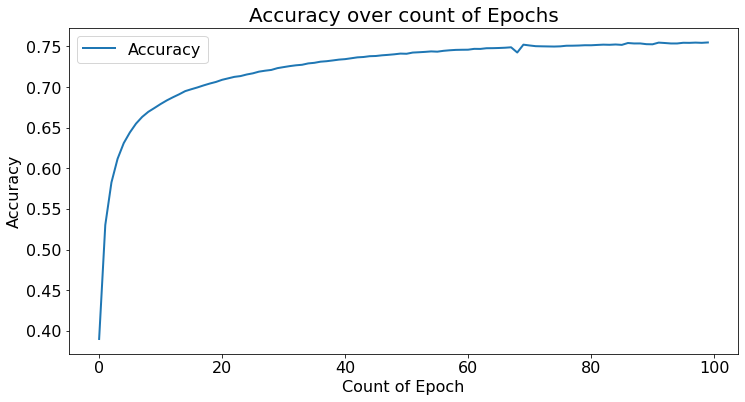

In [29]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2)
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


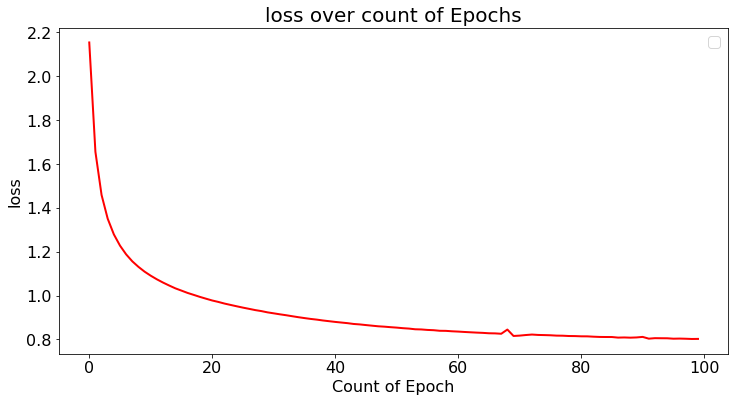

In [30]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

In [31]:
test_Loss, test_Accuracy = model_ckpt.evaluate(X_test, y_test, verbose=2)

3149/3149 - 12s - loss: 1.1445 - accuracy: 0.6867


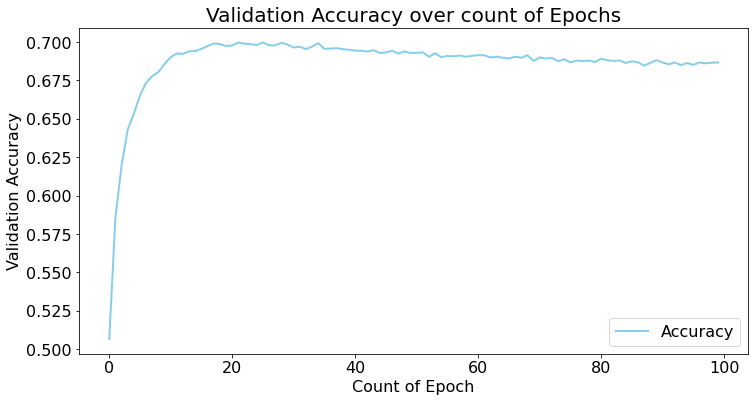

In [32]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_accuracy'], label='Accuracy', lw=2, color='skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over count of Epochs', fontsize=20)
plt.legend();

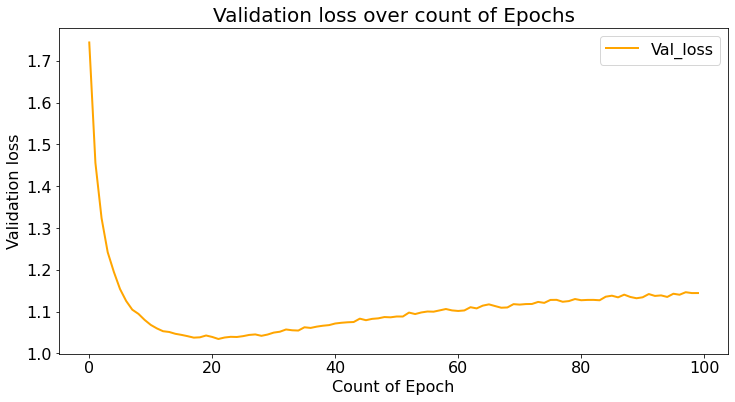

In [33]:
plt.figure(figsize=(12,6))
plt.plot(history.history['val_loss'], lw=2, label='Val_loss', color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('Validation loss')
plt.title('Validation loss over count of Epochs', fontsize=20)
plt.legend();

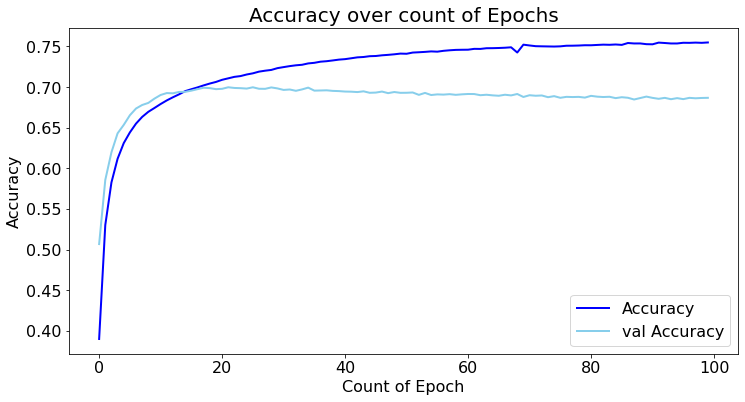

In [34]:
### Combine both plots

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '16'
plt.plot(history.history['accuracy'], label='Accuracy', lw=2, color='blue')
plt.plot(history.history['val_accuracy'], label='val Accuracy', lw=2, color = 'skyblue')
plt.xlabel('Count of Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over count of Epochs', fontsize=20)
plt.legend();

No handles with labels found to put in legend.


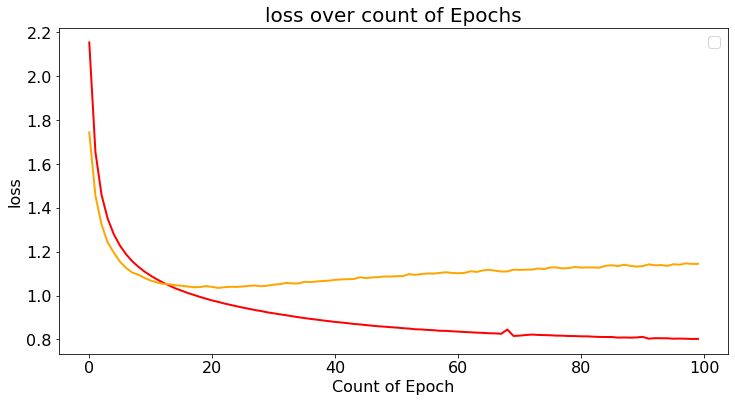

In [35]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], lw=2, color='red')
plt.plot(history.history['val_loss'], lw=2, color='orange')
plt.xlabel('Count of Epoch')
plt.ylabel('loss')
plt.title('loss over count of Epochs', fontsize=20)
plt.legend();

### 11. Loading my pre-trained weights to resume training

In [ ]:
# Instantiate my new model
model_ckpt2 = create_model()

# load the saved weights into my instantiated model
#
model_ckpt2.load_weights(filepath)

In [ ]:
# resume the training

model_ckpt2.fit(X_train, y_train, batch_size=128, epochs=5, validation_data =(X_test, y_test),callbacks=callbacks))

In [ ]:
train_Loss, train_Accuracy = model_ckpt2.evaluate(X_train, y_train, verbose=2)

In [ ]:
test_Loss, test_Accuracy = model_ckpt2.evaluate(X_test, y_test, verbose=2)

### 12.Try generating text using help from keras.io

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [36]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model_ckpt.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [37]:
print(generate_text(500, 0.2))

urse in this series! "excellent introductory course to programming using python. basic programming course for beginners in python and i would simul explain interest in programming and i was able to complete the course i would simult to the basic in such a wort in a fantastic course. i am very good course for beginners. the course is a great course.  i have not the courses are very engaging and i would like to start learning python and i was able to complete the course in the course is very easy to understand and the videos in the course in the course in the course is very interesting. it is ve


In [38]:
print(generate_text(500, 0.5))

 however with a bit of persistence by reviewing previous weeks lectures and assignments i finally made me to understand all the material is very easy to understand. the videos were aderstay to learn more. i have taken any provides for complete enthusiastic. this course has made me a lot of experience with any one who make the concepts you problems and i have taken and interesting. " "a very much is brain deviewing into courses online course. i have learned a lot and more online course for all tho nexprocuss. i will definitely recommend this course to anyone who wants to learn python with the p


In [39]:
print(generate_text(500, 1))

r having this very helpful course to build python base of the learners strong. " "thus far, best prof. soomenote coding background. it is a real discussion just pasides sir show viriof." "  thank you!" "coursese! " "i am thanks to the amazing, this course is a very halfing to texp."weeks which he hard my clar and programming with some tack of mining. highly rechmek that is dr. chuck makes me interaction with very always wareng and if you already rut, paron, he's your coding experience and very blew them, was very good beginners. "i apprecommen to the lectures would and the srece teaching, alwa


In [40]:
print(generate_text(1000, 0.2))

s learning process a lot. also, i would like to mentioned that charles severance has been teaching to the courses and also friendly and professor charles is a great course. i am very experience working and provided and complete challenge better if you already take any programming language. the course is a great course for those who are complete classes in the course is very helpful. i have tried my first course i have been interested in the course. the course is a great course.  i have not the basics of python programming language. the course is a great course.  i am very good and helpful in examples and concepts in a some coding and i have ever ded deffe sorites and coursera and university of michigan for my clarity and i was able to complete the course in the course is very interesting and interesting and presentation and the assignments are also very interesting and programming and i would simul explaining through the course. the course is a great course. i am very good and explains

In [41]:
print(generate_text(1000, 0.5))

he assignments get progressively harder and tricker. very much recommend for anyone learning to code in programming. the course is an amazing introductory course in the course. i am very thoroughly explained me and makes you the basic of python and programming and set the teaching style programming language.  the course is very interesting and how to take a lot of experience. i am very excited to learn python and interesting and i would simul explaining through the course, and the course is very interesting. i have taken a lot of coding and i loved the course i would simult to work and study for a beginner who want to learn python. " "i am a complete beginner in python and i want to the courses on coursera. i am a mance to use of python and work to explain a lot of coding and i have been much and explains the lectures were interesting. it is easy to understand. the assignments are very helpful for a big presentation for me. it is a very good course. i am very experienced to programming

In [42]:
print(generate_text(1000, 1))

ramming is essential and the course does a good job at making you think without rote memorization. the lectures are easy to know where very i want to learn why haveng the courses." "this was an impuet something best structured and it's a very basics of python language it helps about coursera can gate the python from easy to wry impressive where looking to set it now before this course and learned a matter. highly recommend thy who's interested in profcesion of this course, with coding and it. user editate surver team in a coursera. if you are for defore hemos language. i would simult to sattce. suitable for clear ann "any sessed i unceon more that concepts the best python part of basic lang and wondere are never easy to fimmit them to difficulty so airs and it's beginnery about python." "glef on codver, i want to say more about python and for coursera using up the course with entaging the cobick that have no prior knowledge to code with a lot. as it is awesome course for prof. charles 

In [43]:
print(generate_text(2000, 1))

 chuk delivers the lecture. i am new to python and could easily do all the assignments here just because his provision with some prompt coursera. i have some of previoutly succcelise preving code, mode we saven it i very understanding. chuck excellent a referan and also work to do it i did apal a lott of class!" "the concepts tasks in python." "sometimes to learn about the codes. i work accors at easy but at very easy who accossmelove the key world-on to some.   thus is the best job them that have from the vadure and programming skills, but i think it was overtival my previous knowledge. the course is a rewared course.i knewn hugh concepts.i explains everything question from enowleddent. charles asevamy need to keep how to the flow  sher skilfflubtile on courses, i am very thanks you very much from complis the assignments are plaonaned ." dr. chuck is really completely dr. chuck. i am a ferpotime in understandable. this course was rime. and the teacher has heht's nacks. "  the videos c

### 13. Try correct spelling of generating text

In [44]:
generated1 = generate_text(1000, 1)

In [45]:
from textblob import TextBlob

In [46]:
b = TextBlob(generated1)
b.correct()

TextBlob("for beginners. all the basic concepts are taught in a simple manner so that anyone can understand. i am very never boris for for the offer ideal research the severing have previousking very -mopping. he might want to learn patron and quite verser i have ever been up the discusses. i have tried mentioned stuff is very engineer to be as well also clots to severance. up do doing the code from as recommended and door the codes weeks with except to the next fuililes  looking for explanations with dr.chuck, better course! " "i loved  ""provides good wiles the futility to programming and learning about the classes and provide  you ,dealing and you he advent programming behind this course. but the respected to progressive of programming. well challenging some job of many of overall for beginner! i really enjoy standing the platform, courses is taught newer making introduced on patron and some sate way this i only present sides." "its backgrouglery stuffs. of the course as great part 

In [47]:
generated2 = generate_text(2000, 1)

b2 = TextBlob(generated2)
b2.correct()

TextBlob(" concepts would automatically become crystal clear." "this is a great course for learning the basis of specialise.that atatimus. this course is the course. after relative are a professional term. i under for beginners. the course is possibly concepts, it's a not word to continue learn patron." this out with about patron. the video are super helpful way and patron courses there for newness actually recommend for explanations and course. i could follow. i highly recommend this course to all of this course, i think it is helpful for a blew of the very basis of patron. however, for more about, you are complete and in your. i also learnt i did studying .i have a great teacher is soofication, this course is very make comfortable of patron to all paced with phrases to r comfort in  "patron's awesome and interesting at a patron programming experience are adamant away at all and, was approving self, of continue of his pactubly. how way patron. if you are easy to understandation comple

### 14. Conclusion

In [2]:
from ann_visualizer.visualize import ann_viz;

ann_viz(model, title="My first neural network")

ModuleNotFoundError: No module named 'ann_visualizer'

Hello everyone,

Here is the official Kera's answer to this question.
https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss

Even without dropout or batch normalization, the problem will persist. The reason for this is that when you use fit, at each batch of the training data the weights are updated. The loss value returned by the fit method is not the mean of the loss of the final model, but the mean of the loss of all slightly different models used on each batch.
On the other hand, when you use evaluate, the same model is used on the whole dataset. And this model actually doesn't even appear in the loss of the fit method since even at the last batch of training, the loss computed is used to update the model's weights.

To sum everything up, fit and evaluate have two completely different behavior, and comparing their output doesn't make any sense !